In [611]:
import numpy as np
from scipy.interpolate import interp1d
import pylab as pl
%matplotlib inline

In [689]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'  

In [690]:
# Setting velocity and spatial grid points
N_positions = 64
ghost_zones = 3
N_velocity  = 21

In [691]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [692]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0

In [693]:
# Scattering time scale
tau   = 1.0
# Magnitude of maximum velocity
v_max = 5

In [694]:
# Time Parameters for the simulation:
dt         = 0.01 # Size of the time-step
final_time = 1.01
time       = np.arange(dt, final_time, dt)

In [695]:
# Setting up the temperature parameters for the simulations:
T_initial = 1.5

In [696]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [697]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)

In [698]:
# Conversion to allow for easy vectorization
x = x * np.ones([N_velocity , N_positions + 2*ghost_zones])
v = v * np.ones([N_positions + 2*ghost_zones, N_velocity])
v = np.transpose(v)

In [699]:
def calculate_density(f, v):
    deltav           = v[1, 0]-v[0, 0]
    value_of_density = np.sum(f, axis = 0)*deltav
    return(value_of_density)

In [700]:
def calculate_temperature(f, v):
    deltav               = v[1, 0]-v[0, 0]
    value_of_temperature = np.sum(f*v**2, axis = 0)*deltav
    return(value_of_temperature)

In [701]:
def f_interp(dt, x, v, f):
    x_new     = x - v*(dt)
    f_interp  = np.zeros([N_velocity, N_positions + 2*ghost_zones])

    for i in range(N_velocity):
        left_indices   = np.where(x_new[i, ghost_zones:-ghost_zones]<=left_boundary)[0]
        right_indices  = np.where(x_new[i, ghost_zones:-ghost_zones]>=right_boundary)[0]
        wall_indices   = np.concatenate([left_indices, right_indices])
        all_indices    = np.arange(N_positions)
        indices_domain = np.delete(all_indices, wall_indices)
        
        interpolated_function                     = interp1d(x[i, :], f[i, :], 'cubic')
        f_interp[i, ghost_zones + indices_domain] = interpolated_function(x_new[i, ghost_zones + indices_domain])
    
        # Implementation of periodic B.C's
        for j in left_indices:
            while(x_new[i, j + ghost_zones]<left_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] + length

        for j in right_indices:
            while(x_new[i, j + ghost_zones]>right_boundary):
                x_new[i, j + ghost_zones] = x_new[i, j + ghost_zones] - length

        for j in left_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

        for j in right_indices:
            f_interp[i, j + ghost_zones] = interpolated_function(x_new[i, j + ghost_zones])

    return f_interp

In [702]:
# Intializing the values for f
X                           = np.zeros(N_positions + 2*ghost_zones)
X[ghost_zones:-ghost_zones] = np.linspace(0, 2*np.pi, N_positions)
Y                           = 0.1*np.sin(X) + 1
Y[:ghost_zones]             = Y[(N_positions - 1):(N_positions + ghost_zones - 1)]
Y[N_positions + ghost_zones:N_positions + 2 * ghost_zones] = Y[(ghost_zones + 1):(1 + 2*ghost_zones)]

rho_init = Y

rho_init = rho_init * np.ones([N_velocity , N_positions + 2*ghost_zones])

f_initial = rho_init * np.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T_initial)) * \
                       np.exp(-mass_particle*v**2/(2*boltzmann_constant*T_initial))

In [703]:
f_current = f_initial

In [704]:
for time_index in time:
    print(time_index)
    f_new = f_interp(dt, x, v, f_current)

    f_new[:, :ghost_zones] = f_new[:, (N_positions - 1):(N_positions + ghost_zones - 1)]
    f_new[:, N_positions + ghost_zones:N_positions + 2 * ghost_zones] = f_new[:, (ghost_zones + 1):(1 + 2*ghost_zones)]
    f_current = f_new

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0


In [705]:
# Calculating the analytical solution
from scipy.integrate import quad

In [706]:
amplitude   = 0.1
k           = 2*np.pi
theta0      = 1.5
rho0        = 1.0

def rhoInit(x):
    return rho0 + amplitude*np.sin(k*x)

def thetaInit(x):
    return theta0

thetaInit = np.vectorize(thetaInit)

In [707]:
def f0(v, x):    
    rho   = rhoInit(x)
    theta = thetaInit(x)
    
    m = 1.
    k = 1.
        
    return rho * (m/(2*np.pi*k*theta))**(1./2.) * np.exp(-m*v**2./(2.*k*theta))

def f(v, x, t):

    return f0(v, x - v*t)

def rhoIntegrand(v, x, t):

    integralMeasure = 1.0
    
    return integralMeasure * f(v, x, t)

In [708]:
fdiff = (abs(f(v, x, 1.0) - f_new))
print(np.sum(fdiff)/fdiff.size)

7.72395665942e-08


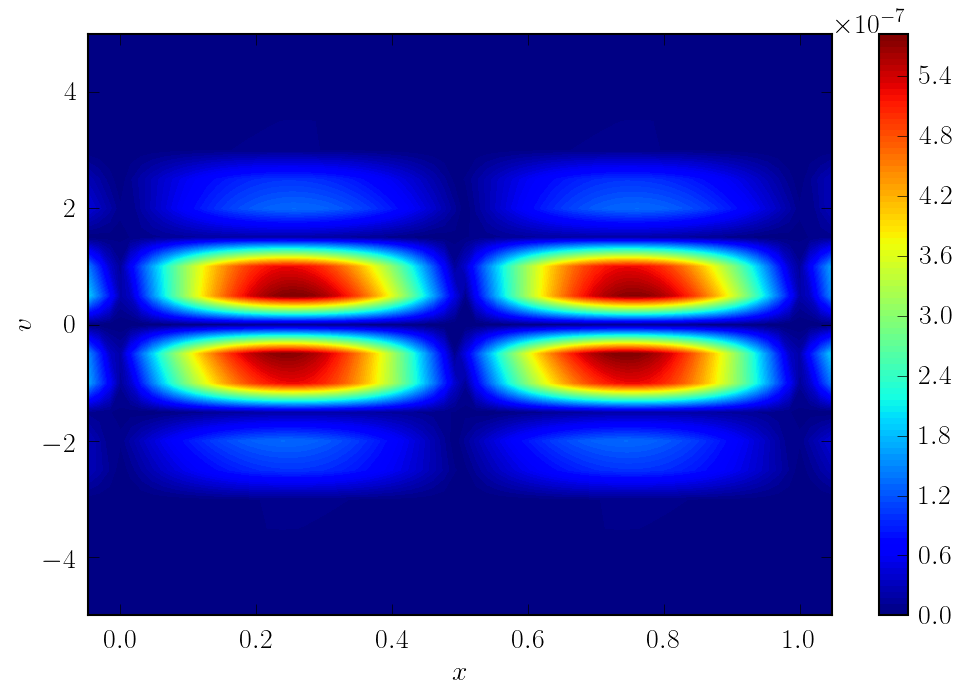

In [709]:
pl.contourf(x, v, fdiff, 100)
pl.xlabel('$x$')
pl.ylabel('$v$')

pl.colorbar()

In [710]:
N = np.array([8, 16, 32, 64, 128])
Error = np.array([0.00181151852517, 0.00183675914992, 0.00194300019663, 0.00189992855311, 0.00186020690249])

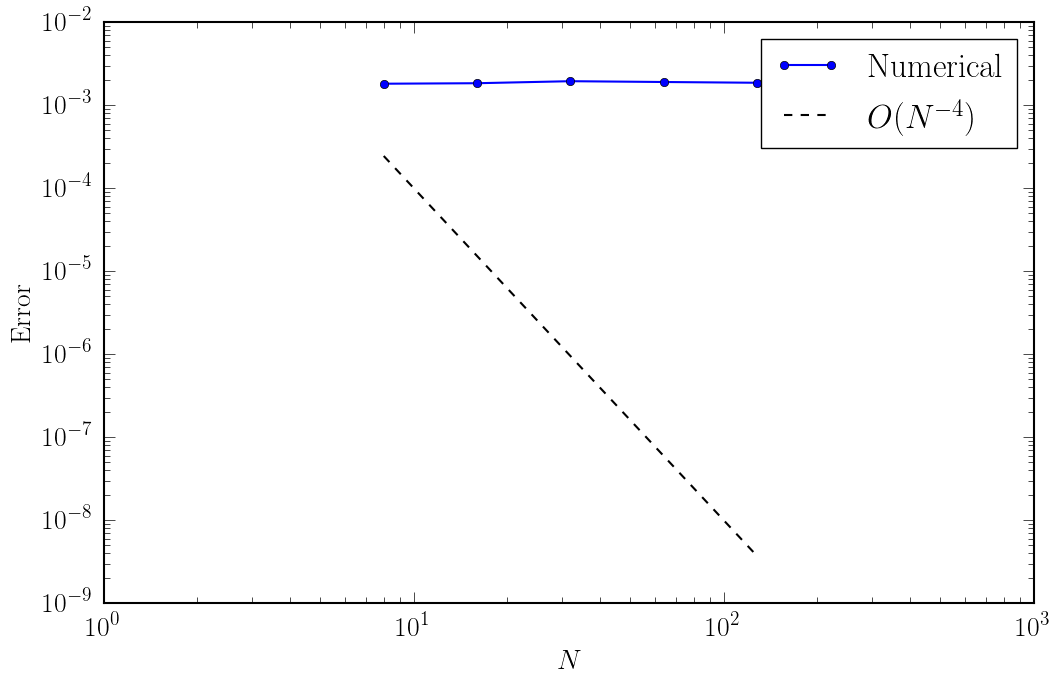

In [634]:
pl.loglog(N, Error, '-o', label = '$\mathrm{Numerical}$')
test_behaviour = N**4
test_behaviour = 1/test_behaviour
pl.loglog(N, test_behaviour, '--', color = 'black', label = '$O(N^{-4})$')
pl.legend(loc = 'best')
pl.xlabel('$N$')
pl.ylabel('$\mathrm{Error}$')